## Setup

In [1]:
!pip install smdebug torch torchvision tqdm boto3
!pip install autogluon --no-cache-dir

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.1/270.1 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.3/83.3 kB 21.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.2/292.2 kB 55.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.1/331.1 kB 349.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.3/218.3 kB 334.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 255.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.7/108.7 kB 300.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 218.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 386.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 MB 258.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━

In [ ]:
# Import
import numpy as np
import pandas as pd
import os
import boto3
from matplotlib import pyplot as plt
%matplotlib inline

session = sagemaker.Session()
role = sagemaker.get_execution_role()
region = session.boto_region_name
bucket = 's3://old-man-mcbucket'
os.environ["DEFAULT_S3_BUCKET"] = bucket

## Data Loading and Preprocessing

In [3]:
# Download data from S3

S3Downloader.download(
    s3_uri=os.path.join(bucket, 'data'),
    local_path='data',
    sagemaker_session=session)

In [2]:
# load into dataframes

df_users = pd.read_json('data/profile.json', lines=True)
df_portfolio = pd.read_json('data/portfolio.json', lines=True)
df_transcript = pd.read_json('data/transcript.json', lines=True)

In [3]:
df_users['became_member_on'] = pd.to_datetime(df_users['became_member_on'], format='%Y%m%d')
df_users.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN


In [4]:
channels = set(df_portfolio['channels'].sum())
for channel in channels:
    df_portfolio[f'is_{channel}'] = df_portfolio['channels'].apply(lambda x: channel in x)
df_portfolio.head()

,reward,channels,difficulty,duration,offer_type,id,is_social,is_web,is_mobile,is_email
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,True,False,True,True
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,True,True,True,True
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,False,True,True,True
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,False,True,True,True
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,False,True,False,True


In [5]:
# extract relevant parameters from the value column
def extract_offer_id(x):
    val = x.get('offer id')
    if val is not None:
        return val
    else:
        val = x.get('offer_id')
        return val

df_transcript['offer_id'] = df_transcript['value'].apply(lambda x: extract_offer_id(x))
df_transcript['transaction_amount'] = df_transcript['value'].apply(lambda x: x.get('amount'))
df_transcript['offer_value'] = df_transcript['value'].apply(lambda x: x.get('reward'))
df_transcript.head()

,person,event,value,time,offer_id,transaction_amount,offer_value
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


## Data Cleaning and Preprocessing

### User data

In [6]:
### Remove null values from dataset
print('Initial shape:', df_users.shape)
df_users.isnull().sum()
df_users.dropna(subset='gender', inplace=True)
df_users = df_users[df_users['age'] != 118]
print('Final shape:', df_users.shape)

Initial shape: (17000, 5)
Final shape: (14825, 5)


## Data Exploration

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'became_member_on'}>],
       [<AxesSubplot:title={'center':'income'}>, <AxesSubplot:>]],
      dtype=object)

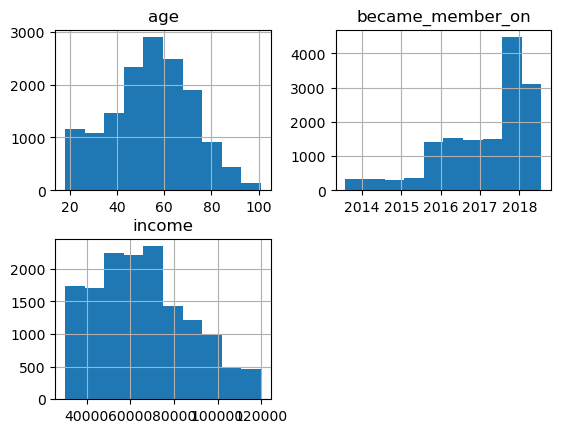

In [9]:
df_users.hist()

# Age is fairly balanced
# Most users signed up in 2017
# Income is right-skewed

In [10]:
df_users.describe()

,age,income
count,14825.000000,14825.000000
mean,54.393524,65404.991568
std,17.383705,21598.299410
min,18.000000,30000.000000
25%,42.000000,49000.000000
50%,55.000000,64000.000000
75%,66.000000,80000.000000
max,101.000000,120000.000000


In [11]:
# Compute a propensity score for each user
# propensity = # of completed offers / # of viewed offers
# propensity must be between 0 and 1
# if propensity exceeds 1, then it means that users completed offers without viewing them

df_transcript['is_completed'] = df_transcript['event'] == 'offer completed'
df_transcript['is_viewed'] = df_transcript['event'] == 'offer viewed'
df_transcript['is_received'] = df_transcript['event'] == 'offer received'

user_agg = df_transcript.groupby(['person', 'offer_id'])[['is_received', 'is_viewed', 'is_completed']].sum()
user_agg['propensity'] = user_agg['is_completed'] / user_agg['is_viewed']
user_agg['completed without viewing'] = (user_agg['is_completed'] - user_agg['is_viewed']).apply(lambda x: max(0, x))

In [12]:
# Aggeregate by offer type
offer_status = user_agg.reset_index().groupby('offer_id')[['is_received', 'is_viewed', 'is_completed', 'completed without viewing']].sum()
offer_status_details = offer_status.merge(df_portfolio, left_index=True, right_on = 'id')
offer_status_compiled = offer_status_details.groupby('offer_type').sum()
offer_status_compiled['proportion not viewed'] = offer_status_compiled['completed without viewing'] / offer_status_compiled['is_completed']
offer_status_compiled['view rate'] = offer_status_compiled['is_viewed'] / offer_status_compiled['is_received']
offer_status_compiled['completion rate'] = offer_status_compiled['is_completed'] / offer_status_compiled['is_received']

offer_status_compiled

,is_received,is_viewed,is_completed,completed without viewing,reward,difficulty,duration,is_social,is_web,is_mobile,is_email,proportion not viewed,view rate,completion rate
offer_type,,,,,,,,,,,,,,
bogo,30499,25449,15669,2193,30,30,24,3,3,4,4,0.139958,0.834421,0.513755
discount,30543,21445,17910,3436,12,47,34,2,4,3,4,0.191848,0.702125,0.586386
informational,15235,10831,0,0,0,0,7,1,1,2,2,NaN,0.710929,0.000000


Text(0, 0.5, 'View Rate')

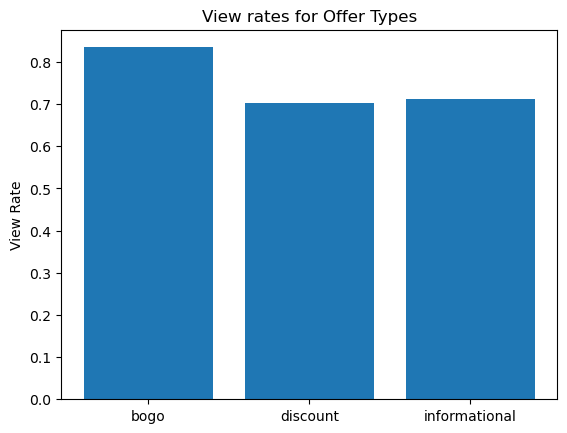

In [13]:
plt.bar(offer_status_compiled.index, offer_status_compiled['view rate'])
plt.title('View rates for Offer Types')
plt.ylabel('View Rate')
# BOGO seems to have an overall higher view rate compared to the other offers

Text(0, 0.5, 'View Rate')

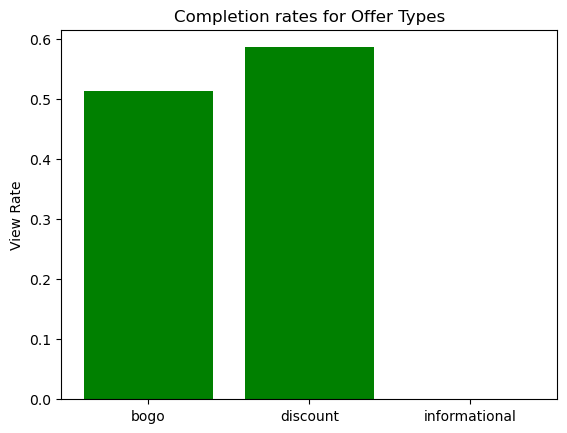

In [14]:
plt.bar(offer_status_compiled.index, offer_status_compiled['completion rate'], color='g')
plt.title('Completion rates for Offer Types')
plt.ylabel('View Rate')

# Discount has a higher completion rate in comparison

## Data Transformation + Feature Engineering

Input data = combination of user profile + offer  
output = probability of engagement


In [15]:
# Engineering features from users
df_users['month_signup'] = df_users['became_member_on'].dt.month
df_users['year_signup'] = df_users['became_member_on'].dt.year
df_users['day_signup'] = df_users['became_member_on'].dt.day

Text(0, 0.5, 'Proportion')

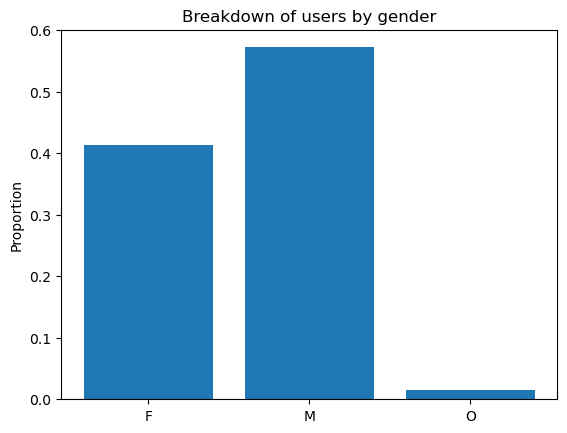

In [16]:
axis = 'gender'

proportions = df_users.groupby(axis).count() / df_users.shape[0]

plt.bar(proportions.index, proportions['age'])
plt.title(f'Breakdown of users by {axis}')
plt.ylabel('Proportion')

# Majority of users are male

In [ ]:
# reduce to useful features

user_features = ['gender', 'age', 'income', 'month_signup', 'year_signup', 'day_signup']
offer_features = ['is_web', 'is_social', 'is_email', 'is_mobile', 'reward', 'difficulty', 'duration', 'offer_type']

# if user completed no offers without viewing beforehand then they are not influenced for the sake of this model
target_value = user_agg['propensity'].apply(lambda x: 0 if x > 1000 else max(0, min(1, x))).reset_index()
target_value.fillna(0, inplace=True)

df_users['key'] = 1
df_users['person'] = df_users['id']
df_portfolio['key'] = 1
df_portfolio['offer_id'] = df_portfolio['id']

final_df = pd.merge(
    target_value,
    pd.merge(df_users, df_portfolio, on='key', how='inner'),
    on=['person', 'offer_id'], how='inner'
)

final_df = final_df[['propensity'] + user_features + offer_features]
final_df = pd.get_dummies(final_df)

In [ ]:
final_df.to_csv('final_data.csv')

In [ ]:
# Mostly binary and roughly an even split, but there are some users with p ~ 0.5
plt.hist(target_value)
plt.xlabel('User Propensity Score')
plt.ylabel('User Count (log scale)')
plt.yscale('log')

## Model setup

In [ ]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(final_df, test_size=0.4)
validation_data, test_data = train_test_split(final_df, test_size=0.5)

print(f'Train:{train_data.shape[0]}')
print('Test:{test_data.shape[0]}')
print(f'Validation:{validation_data.shape[0]}')

In [ ]:
from autogluon.tabular import TabularPredictor

predictor = TabularPredictor(
    label='propensity', eval_metric='f1',
    problem_type='binary',
).fit(final_df, time_limit=600,
      presets='best_quality'
)